## a)

In [2]:
from matplotlib import pyplot as plt

def show_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

In [3]:
# read saffrun.jpg image using cv2.imread() function
# remove the noise from the image using FFT
import numpy as np

def remove_noise_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    # calculate amplitude spectrum
    mag_spec = 20*np.log(np.abs(fshift))

    r = f.shape[0]//2        # number of rows/2
    c = f.shape[1]//2        # number of columns/2   
    p = 3                         
    n = 1                   # to suppress all except for the DC component       
    fshift2 = np.copy(fshift)
    
    # suppress upper part
    fshift2[0:r-n , c-p:c+p] = 0.001
    # suppress lower part
    fshift2[r+n:r+r, c-p:c+p] = 0.001


    # calculate new amplitude spectrum
    mag_spec2 = 20*np.log(np.abs(fshift2))
    inv_fshift = np.fft.ifftshift(fshift2)
    # reconstruct image
    img_recon = np.real(np.fft.ifft2(inv_fshift))
    
    return img_recon, mag_spec, mag_spec2


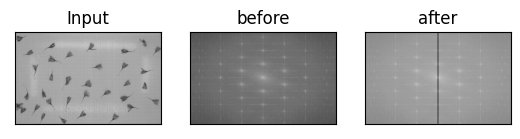

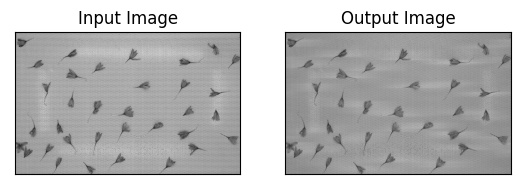

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('images/soldier.jpg', 0)
img_recon, mag_spec, mag_spec2 = remove_noise_fft(img)

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mag_spec, cmap = 'gray')
plt.title('before'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mag_spec2, cmap = 'gray')
plt.title('after'), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure()
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_recon, cmap = 'gray')
plt.title('Output Image'), plt.xticks([]), plt.yticks([])
plt.show()
    

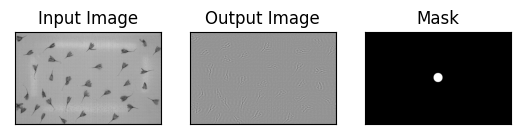

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
img = cv2.imread('images/saffrun.jpg', 0)

# Apply Fourier Transform
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# Create a mask
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
mask = np.zeros((rows, cols), np.uint8)
r = 40
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
mask[mask_area] = 1

# Apply the mask
fshift_filtered = fshift * (1 - mask)
fshift_filtered_shifted = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(fshift_filtered_shifted)
img_back = np.real(img_back)

# Display the images with plt
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])    
plt.subplot(132), plt.imshow(img_back, cmap='gray')
plt.title('Output Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(mask, cmap='gray')
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.show()



Enter type of noise:- 
1.Vertical Noise
2.Horizontal Noise
3.Right Diagonal Noise
4.Left Diagonal Noise



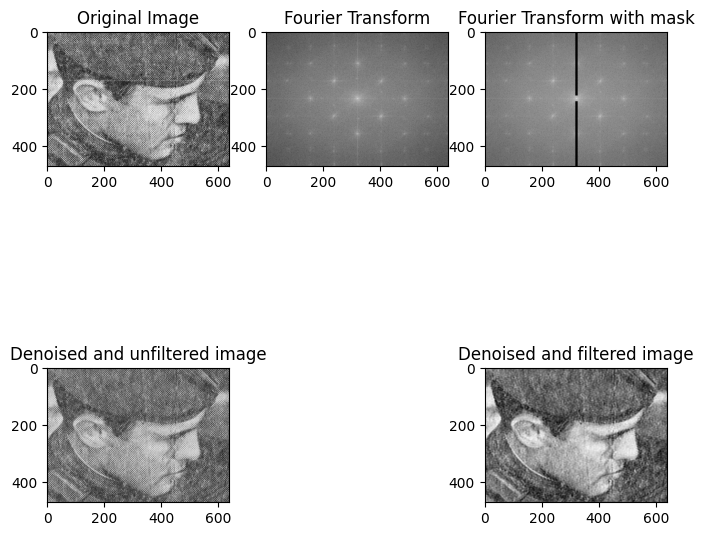

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base


img = cv2.imread('images/soldier.jpg', 0)

fourier_transform = np.fft.fft2(img)
center_shift = np.fft.fftshift(fourier_transform)

fourier_noisy = 20 * np.log(np.abs(center_shift))

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

print("Enter type of noise:- \n1.Vertical Noise\n2.Horizontal Noise\n3.Right Diagonal Noise\n4.Left Diagonal Noise\n")
val = int(input("Enter the Value:- "))

if val == 1:
    # horizontal mask
    center_shift[crow - 4:crow + 4, 0:ccol - 10] = 1
    center_shift[crow - 4:crow + 4, ccol + 10:] = 1
elif val == 2:
    # vertical mask
    center_shift[:crow - 10, ccol - 4:ccol + 4] = 1
    center_shift[crow + 10:, ccol - 4:ccol + 4] = 1
elif val == 3:
    # diagonal-1 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x == y):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
elif val == 4:
    # diagonal-2 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x + y == cols):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
elif val == 5:
    # Gaussian mask
    center_shift[crow - 20:crow + 20, ccol - 20:ccol + 20] = 1

else:
    print("Invalid Input")

filtered = center_shift * butterworthLP(80, img.shape, 10)

f_shift = np.fft.ifftshift(center_shift)
denoised_image = np.fft.ifft2(f_shift)
denoised_image = np.real(denoised_image)

f_ishift_blpf = np.fft.ifftshift(filtered)
denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
denoised_image_blpf = np.real(denoised_image_blpf)

fourier_noisy_noise_removed = 20 * np.log(np.abs(center_shift))

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 3, 1)
ax1.title.set_text("Original Image")
ax1.imshow(img, cmap='gray')
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(fourier_noisy, cmap='gray')
ax2.title.set_text("Fourier Transform")
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(fourier_noisy_noise_removed, cmap='gray')
ax3.title.set_text("Fourier Transform with mask")
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(denoised_image, cmap='gray')
ax4.title.set_text("Denoised and unfiltered image")
ax5 = fig.add_subplot(2, 3, 6)
ax5.imshow(denoised_image_blpf, cmap='gray')
ax5.title.set_text("Denoised and filtered image")



plt.show()